# Setup

In [1]:
!python --version

Python 3.8.13


In [2]:
!nvidia-smi

Sun Nov 20 13:31:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.43       Driver Version: 456.43       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  TCC  | 00000001:00:00.0 Off |                  Off |
| N/A   30C    P0    25W / 250W |      1MiB / 16258MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [3]:
import os
os.environ["PYTHONHASHSEED"] = str(42)
import sys
sys.path.append("C:\\Miniconda\\envs\\kogas_env1\\Lib\\site-packages")
import shutil
import datetime
import random as rnd
from glob import glob
import gc
import optuna
from optuna import Trial, create_study
from optuna.samplers import TPESampler
import pickle
import copy

import numpy as np
from numpy import random as np_rnd
import pandas as pd
from scipy.stats import linregress
from scipy.stats import trim_mean

from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn import metrics as skl_merics
from sklearn.decomposition import PCA

import sklearn as skl
from sklearn import linear_model as lm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import ExtraTreeRegressor

import lightgbm as lgb
import xgboost as xgb
import catboost as cat

from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action="ignore")

pd.set_option("display.max_rows", 50)

plt.rcParams["axes.unicode_minus"] = False
font_path = "C:\\Users\\kogas\\Desktop\\nanum-square\\NanumSquareR.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

In [4]:
def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    rnd.seed(seed)
    np_rnd.seed(seed)

def diff(x1, x2):
    x2 = set(x2)
    return [i for i in x1 if i not in x2]

def softmax(x, multiplier=2.0):
    x = x * multiplier
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def pickleIO(obj, src, mode="r"):
    if mode == "w":
        with open(src, "wb") as f:
            pickle.dump(obj, f)
        return 0
    else:
        with open(src, "rb") as f:
            obj = pickle.load(f)
        return obj
    
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory. ' + directory)

In [5]:
class CFG:
    debug = False
    train_timesteps = 60
    test_timesteps = 168
    pca_threshold = 0.9
    n_folds = 5
    
    quarter_dic = {
    "Q1": [1, 2, 3],
    "Q2": [4, 5, 6],
    "Q3": [7, 8, 9],
    "Q4": [10, 11, 12],
    }
    # df_indust 에는 쿼터가 없기 때문에, 다른 데이터에 쿼터를 달아준다
    month_dic = {
        1 : 'Q1',
        2 : 'Q1',
        3 : 'Q1',
        4 : 'Q2',
        5 : 'Q2',
        6 : 'Q2',
        7 : 'Q3',
        8 : 'Q3',
        9 : 'Q3',
        10 : 'Q4',
        11 : 'Q4',
        12 : 'Q4'
    }

In [6]:
folder_path = "C:\\Users\\kogas\\Desktop\\jupyter_root_folder\\YJ_notebooks\\"
# C:\Users\kogas\Desktop\jupyter_root_folder\YJ_notebooks
seed_everything()

In [7]:
target_vars = ["target_civil", "target_ind"]
nontrain_vars = ["year"]
bin_vars = []
cat_vars = ["quarter", "month"]

## 기본제공 데이터셋 Loading & Preprocessing

In [8]:
df_supply = pd.read_csv(folder_path + 'dataset\\월별공급량및비중.csv')
df_supply.columns = ["year", "month", "target_civil", "target_ind", "total", "weight_civil", "weight_ind"]
df_indust = pd.read_csv(folder_path + 'dataset\\제조업 부가가치(분기별).csv')
df_indust.columns = ["year", "quarter", "qva"]
df_commer = pd.read_csv(folder_path + 'dataset\\상업용 상대가격(기준=2015).csv')
df_commer.columns = ["year", "month", "relative_price", "gas_price", "oil_price"]

In [9]:
df_supply["quarter"] = df_supply["month"].apply(lambda x: CFG.month_dic[x])
df_indust["month"] = df_indust["quarter"].apply(lambda x: CFG.quarter_dic[x])
df_commer["quarter"] = df_commer["month"].apply(lambda x: CFG.month_dic[x])

In [10]:
df_supply[["year", "month"]] = df_supply[["year", "month"]].astype("int32")
df_supply.head()

,year,month,target_civil,target_ind,total,weight_civil,weight_ind,quarter
0,1996,1,605519.0,83809.0,689328.0,0.87842,0.12158,Q1
1,1996,2,566323.0,70427.0,636750.0,0.88940,0.11060,Q1
2,1996,3,477514.0,62652.0,540166.0,0.88401,0.11599,Q1
3,1996,4,337794.0,47050.0,384844.0,0.87774,0.12226,Q2
4,1996,5,184522.0,30709.0,215231.0,0.85732,0.14268,Q2


In [11]:
df_indust = df_indust.explode("month")
df_indust["qva"] /= 3
df_indust[["year", "month"]] = df_indust[["year", "month"]].astype("int32")
df_indust.head()

,year,quarter,qva,month
0,1996,Q1,12183.433333,1
0,1996,Q1,12183.433333,2
0,1996,Q1,12183.433333,3
1,1996,Q2,12384.133333,4
1,1996,Q2,12384.133333,5


In [12]:
df_commer[["year", "month"]] = df_commer[["year", "month"]].astype("int32")
df_commer.head()

,year,month,relative_price,gas_price,oil_price,quarter
0,1996,1,0.97,26.94,27.86,Q1
1,1996,2,0.93,26.94,29.04,Q1
2,1996,3,0.96,26.94,27.99,Q1
3,1996,4,0.94,26.94,28.74,Q2
4,1996,5,0.92,26.94,29.18,Q2


In [13]:
df_full = df_supply[["year", "quarter", "month"]]
concat_list = [df_supply, df_indust, df_commer]
for i in concat_list:  
    df_full = pd.merge(df_full, i, on=["year", "quarter", "month"], how="left")

In [14]:
# df_full.columns = ["year", "month", "target_civil", "target_ind", "total", "weight_civil", "weight_ind", "quarter", "qva", "qva_norm2015", "relative_price", "price_gas", "price_oil"]
df_full = df_full.drop(["weight_ind", "total"], axis=1)
# df_test.columns = ["year", "month", "target_civil", "target_ind"]

In [15]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            300 non-null    int32  
 1   quarter         300 non-null    object 
 2   month           300 non-null    int32  
 3   target_civil    300 non-null    float64
 4   target_ind      300 non-null    float64
 5   weight_civil    300 non-null    float64
 6   qva             300 non-null    float64
 7   relative_price  300 non-null    float64
 8   gas_price       300 non-null    float64
 9   oil_price       300 non-null    float64
dtypes: float64(7), int32(2), object(1)
memory usage: 23.4+ KB


In [16]:
df_full.head()

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price
0,1996,Q1,1,605519.0,83809.0,0.87842,12183.433333,0.97,26.94,27.86
1,1996,Q1,2,566323.0,70427.0,0.88940,12183.433333,0.93,26.94,29.04
2,1996,Q1,3,477514.0,62652.0,0.88401,12183.433333,0.96,26.94,27.99
3,1996,Q2,4,337794.0,47050.0,0.87774,12384.133333,0.94,26.94,28.74
4,1996,Q2,5,184522.0,30709.0,0.85732,12384.133333,0.92,26.94,29.18


In [17]:
tmp = pd.DataFrame(
    {
        "year": pd.date_range("2021-01-01", "2034-12-31", freq="MS").year,
        "month": pd.date_range("2021-01-01", "2034-12-31", freq="MS").month,
        "quarter": "Q1",
        "target_civil": np.nan,
        "weight_civil": np.nan,
        "qva": np.nan,
        "relative_price": np.nan,
        "gas_price": np.nan,
        "oil_price": np.nan,
    }
)

df_full = pd.concat([df_full, tmp], axis=0, ignore_index=True)

In [18]:
df_full[["year", "month"]] = df_full[["year", "month"]].astype("int32")

In [19]:
df_full["quarter"] = df_full["month"].apply(lambda x: CFG.month_dic[x])

In [20]:
df_full

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price
0,1996,Q1,1,605519.0,83809.0,0.87842,12183.433333,0.97,26.94,27.86
1,1996,Q1,2,566323.0,70427.0,0.88940,12183.433333,0.93,26.94,29.04
2,1996,Q1,3,477514.0,62652.0,0.88401,12183.433333,0.96,26.94,27.99
3,1996,Q2,4,337794.0,47050.0,0.87774,12384.133333,0.94,26.94,28.74
4,1996,Q2,5,184522.0,30709.0,0.85732,12384.133333,0.92,26.94,29.18
...,...,...,...,...,...,...,...,...,...,...
463,2034,Q3,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
464,2034,Q3,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
465,2034,Q4,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
466,2034,Q4,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 외부데이터셋 Loading & Preprocessing

### 온도

In [21]:
tmp_df = []

for i in glob(folder_path + "external_data\\20220930\\기온\\*"):
    if i.split("\\")[-1][:2] in ["서울", "인천", "대전", "대구", "광주", "울산", "부산"]:
        tmp = pd.read_csv(i, encoding="cp949")
        tmp = tmp.iloc[:, 1:]
        tmp.columns = ["지점명", "일시", "평균기온", "최고기온", "최고기온시각", "최저기온", "최저기온시각", "일교차"]
        tmp = tmp[["지점명", "일시", "평균기온", "최고기온", "최저기온", "일교차"]]
        tmp["일시"] = pd.to_datetime(tmp["일시"])
        tmp["year"] = tmp["일시"].dt.year
        tmp["month"] = tmp["일시"].dt.month
        tmp = tmp.loc[(tmp["일시"] >= pd.to_datetime("1996-01-01")) &( tmp["일시"] <= pd.to_datetime("2020-12-31"))]
        tmp_df.append(tmp)

tmp_df = pd.concat(tmp_df, axis=0, ignore_index=True)

In [22]:
tmp_df.head()

,지점명,일시,평균기온,최고기온,최저기온,일교차,year,month
0,광주,1996-01-01,0.3,5.3,-3.5,8.8,1996.0,1.0
1,광주,1996-01-02,1.9,10.1,-5.7,15.8,1996.0,1.0
2,광주,1996-01-03,0.5,6.4,-3.9,10.3,1996.0,1.0
3,광주,1996-01-04,-2.0,3.9,-6.4,10.3,1996.0,1.0
4,광주,1996-01-05,4.1,9.9,-2.6,12.5,1996.0,1.0


In [23]:
# df_full[["전국평균_" + str(i) for i in tmp_df.groupby(["year", "month"]).mean().columns]] = tmp_df.groupby(["year", "month"]).mean().values
# df_full[["전국표준편차_" + str(i) for i in tmp_df.groupby(["year", "month"]).mean().columns]] = tmp_df.groupby(["year", "month"]).std().values
# df_full[["서울_" + str(i) for i in tmp_df.groupby(["year", "month"]).mean().columns]] = tmp_df.loc[tmp_df["지점명"] == "서울"].groupby(["year", "month"]).mean().values
# df_full[["부산_" + str(i) for i in tmp_df.groupby(["year", "month"]).mean().columns]] = tmp_df.loc[tmp_df["지점명"] == "부산"].groupby(["year", "month"]).mean().values

### projection

In [24]:
tmp_mapper = tmp_df.loc[tmp_df["지점명"] == "서울"].groupby(["year", "month"]).mean()["최고기온"].iloc[-(12 * 10):].groupby("month").mean()
tmp_mapper.index = tmp_mapper.index.astype("int32")

In [25]:
tmp_mapper

month
1      1.956452
2      5.059433
3     11.844516
4     17.996333
5     24.521290
6     28.523000
7     29.642903
8     30.768387
9     26.659000
10    20.743323
11    12.210000
12     3.460645
Name: 최고기온, dtype: float64

In [26]:
df_full["서울_최고기온"] = np.nan
df_full.loc[(df_full["year"] <= 2020), "서울_최고기온"] = tmp_df.loc[tmp_df["지점명"] == "서울"].groupby(["year", "month"]).mean()["최고기온"].values
df_full.loc[(df_full["year"] > 2020), "서울_최고기온"] = df_full.loc[(df_full["year"] > 2020), "month"].map(tmp_mapper)

In [27]:
df_full

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price,서울_최고기온
0,1996,Q1,1,605519.0,83809.0,0.87842,12183.433333,0.97,26.94,27.86,2.329032
1,1996,Q1,2,566323.0,70427.0,0.88940,12183.433333,0.93,26.94,29.04,3.182759
2,1996,Q1,3,477514.0,62652.0,0.88401,12183.433333,0.96,26.94,27.99,9.451613
3,1996,Q2,4,337794.0,47050.0,0.87774,12384.133333,0.94,26.94,28.74,15.143333
4,1996,Q2,5,184522.0,30709.0,0.85732,12384.133333,0.92,26.94,29.18,24.196774
...,...,...,...,...,...,...,...,...,...,...,...
463,2034,Q3,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.768387
464,2034,Q3,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.659000
465,2034,Q4,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.743323
466,2034,Q4,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.210000


### 습도

In [28]:
tmp_df = []

for i in glob(folder_path + "external_data\\20221008\\습도\\*"):
    if i.split("\\")[-1][:2] in ["서울", "인천", "대전", "대구", "광주", "울산", "부산"]:
        tmp = pd.read_csv(i, encoding="cp949")
        tmp = tmp.iloc[:, 1:]
        tmp.columns = ["지점명", "일시", "평균습도", "최저습도"]
        tmp = tmp[["지점명", "일시", "평균습도", "최저습도"]]
        tmp["일시"] = pd.to_datetime(tmp["일시"])
        tmp["year"] = tmp["일시"].dt.year
        tmp["month"] = tmp["일시"].dt.month
        tmp = tmp.loc[(tmp["일시"] >= pd.to_datetime("1996-01-01")) & (tmp["일시"] <= pd.to_datetime("2020-12-31"))]
        tmp_df.append(tmp)
    else:
        continue
#     break

tmp_df = pd.concat(tmp_df, axis=0, ignore_index=True)

In [29]:
tmp_df.head()

,지점명,일시,평균습도,최저습도,year,month
0,광주,1996-01-01,43.8,22.0,1996.0,1.0
1,광주,1996-01-02,70.8,45.0,1996.0,1.0
2,광주,1996-01-03,75.5,54.0,1996.0,1.0
3,광주,1996-01-04,66.3,48.0,1996.0,1.0
4,광주,1996-01-05,73.3,51.0,1996.0,1.0


In [30]:
# df_full[["전국평균_" + str(i) for i in tmp_df.groupby(["year", "month"]).mean().columns]] = tmp_df.groupby(["year", "month"]).mean().values
# df_full[["전국표준편차_" + str(i) for i in tmp_df.groupby(["year", "month"]).mean().columns]] = tmp_df.groupby(["year", "month"]).std().values
# df_full[["서울_" + str(i) for i in tmp_df.groupby(["year", "month"]).mean().columns]] = tmp_df.loc[tmp_df["지점명"] == "서울"].groupby(["year", "month"]).mean().values
# df_full[["부산_" + str(i) for i in tmp_df.groupby(["year", "month"]).mean().columns]] = tmp_df.loc[tmp_df["지점명"] == "부산"].groupby(["year", "month"]).mean().values

### projection

In [31]:
tmp_mapper = tmp_df.loc[tmp_df["지점명"] == "부산"].groupby(["year", "month"]).mean()["평균습도"].iloc[-(12 * 10):].groupby("month").mean()
tmp_mapper.index = tmp_mapper.index.astype("int32")

In [32]:
tmp_mapper

month
1     44.846129
2     49.865542
3     55.192903
4     59.855000
5     65.597419
6     75.640667
7     81.678065
8     76.255806
9     72.548333
10    62.437742
11    57.043667
12    48.040000
Name: 평균습도, dtype: float64

In [33]:
df_full["부산_평균습도"] = np.nan
df_full.loc[(df_full["year"] <= 2020), "부산_평균습도"] = tmp_df.loc[tmp_df["지점명"] == "부산"].groupby(["year", "month"]).mean()["평균습도"].values
df_full.loc[(df_full["year"] > 2020), "부산_평균습도"] = df_full.loc[(df_full["year"] > 2020), "month"].map(tmp_mapper)

In [34]:
df_full

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price,서울_최고기온,부산_평균습도
0,1996,Q1,1,605519.0,83809.0,0.87842,12183.433333,0.97,26.94,27.86,2.329032,43.629032
1,1996,Q1,2,566323.0,70427.0,0.88940,12183.433333,0.93,26.94,29.04,3.182759,46.496552
2,1996,Q1,3,477514.0,62652.0,0.88401,12183.433333,0.96,26.94,27.99,9.451613,55.432258
3,1996,Q2,4,337794.0,47050.0,0.87774,12384.133333,0.94,26.94,28.74,15.143333,51.770000
4,1996,Q2,5,184522.0,30709.0,0.85732,12384.133333,0.92,26.94,29.18,24.196774,65.793548
...,...,...,...,...,...,...,...,...,...,...,...,...
463,2034,Q3,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.768387,76.255806
464,2034,Q3,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.659000,72.548333
465,2034,Q4,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.743323,62.437742
466,2034,Q4,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.210000,57.043667


### 인구

In [35]:
tmp_df = pd.read_csv(folder_path + "external_data\\20221011\\korea_pop_popGR.csv")
tmp_df.columns = ["year", "korea_pop", "korea_pop_gr"]
tmp_df["month"] = 12

In [36]:
tmp_df

,year,korea_pop,korea_pop_gr,month
0,1960,"25,012",-,12
1,1961,"25,766",2.97,12
2,1962,"26,513",2.86,12
3,1963,"27,262",2.78,12
4,1964,"27,984",2.62,12
...,...,...,...,...
106,2066,"39,575",-1.24,12
107,2067,"39,086",-1.24,12
108,2068,"38,603",-1.24,12
109,2069,"38,126",-1.24,12


In [37]:
tmp_df["korea_pop"] = tmp_df["korea_pop"].apply(lambda x: float(x.replace(",", "")))
tmp_df["korea_pop_gr"] = tmp_df["korea_pop_gr"].apply(lambda x: np.nan if x == "-" else float(x.replace(",", "")))

# 성장률을 월간으로 평균한 값을 미리 계산
tmp_df["korea_pop_gr"] = (((1 + tmp_df["korea_pop_gr"] / 100) ** (1/12)) - 1) * 100

In [38]:
tmp_df.head()

,year,korea_pop,korea_pop_gr,month
0,1960,25012.0,NaN,12
1,1961,25766.0,0.244193,12
2,1962,26513.0,0.235265,12
3,1963,27262.0,0.228766,12
4,1964,27984.0,0.215755,12


In [39]:
df_full = df_full.merge(tmp_df, on=["year", "month"], how="left")
df_full["korea_pop"] = df_full["korea_pop"].interpolate().bfill().ffill()
# df_full["korea_pop_gr"] = df_full["korea_pop_gr"].bfill().ffill()
df_full = df_full.drop("korea_pop_gr", axis=1)

In [40]:
df_full

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price,서울_최고기온,부산_평균습도,korea_pop
0,1996,Q1,1,605519.0,83809.0,0.87842,12183.433333,0.97,26.94,27.86,2.329032,43.629032,45525.000000
1,1996,Q1,2,566323.0,70427.0,0.88940,12183.433333,0.93,26.94,29.04,3.182759,46.496552,45525.000000
2,1996,Q1,3,477514.0,62652.0,0.88401,12183.433333,0.96,26.94,27.99,9.451613,55.432258,45525.000000
3,1996,Q2,4,337794.0,47050.0,0.87774,12384.133333,0.94,26.94,28.74,15.143333,51.770000,45525.000000
4,1996,Q2,5,184522.0,30709.0,0.85732,12384.133333,0.92,26.94,29.18,24.196774,65.793548,45525.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2034,Q3,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.768387,76.255806,50971.666667
464,2034,Q3,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.659000,72.548333,50965.750000
465,2034,Q4,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.743323,62.437742,50959.833333
466,2034,Q4,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.210000,57.043667,50953.916667


### GDP

In [41]:
tmp_df = pd.read_csv(folder_path + "external_data\\20221117\\year_gdp_forecasting\\oced_forcasting.csv")
tmp_df.columns = tmp_df.columns.str.lower()
tmp_df["month"] = 12
tmp_df = tmp_df.loc[(tmp_df["location"] == "KOR"), ["time", "month", "value"]]
tmp_df.columns = ["year", "month", "gdp"]
tmp_df[["year", "month"]] = tmp_df[["year", "month"]].astype("int32")

In [42]:
tmp_df

,year,month,gdp
1064,1990,12,5.296235e+05
1065,1991,12,5.867067e+05
1066,1992,12,6.230744e+05
1067,1993,12,6.659263e+05
1068,1994,12,7.276487e+05
...,...,...,...
1130,2056,12,2.877322e+06
1131,2057,12,2.876209e+06
1132,2058,12,2.874752e+06
1133,2059,12,2.872951e+06


### projection

In [43]:
df_full = pd.merge(df_full, tmp_df, how="left", on=["year", "month"])
df_full["gdp"] /= 12
df_full["gdp"] = df_full["gdp"].bfill().ffill()

In [44]:
df_full

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price,서울_최고기온,부산_평균습도,korea_pop,gdp
0,1996,Q1,1,605519.0,83809.0,0.87842,12183.433333,0.97,26.94,27.86,2.329032,43.629032,45525.000000,71712.160799
1,1996,Q1,2,566323.0,70427.0,0.88940,12183.433333,0.93,26.94,29.04,3.182759,46.496552,45525.000000,71712.160799
2,1996,Q1,3,477514.0,62652.0,0.88401,12183.433333,0.96,26.94,27.99,9.451613,55.432258,45525.000000,71712.160799
3,1996,Q2,4,337794.0,47050.0,0.87774,12384.133333,0.94,26.94,28.74,15.143333,51.770000,45525.000000,71712.160799
4,1996,Q2,5,184522.0,30709.0,0.85732,12384.133333,0.92,26.94,29.18,24.196774,65.793548,45525.000000,71712.160799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2034,Q3,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.768387,76.255806,50971.666667,231892.166667
464,2034,Q3,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.659000,72.548333,50965.750000,231892.166667
465,2034,Q4,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.743323,62.437742,50959.833333,231892.166667
466,2034,Q4,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.210000,57.043667,50953.916667,231892.166667


###  Energy

### projection civil natural gas consumption (linear inference by gdp)

In [45]:
tmp_df = df_full.groupby("year")[["target_civil", "gdp"]].sum()
model = lm.LinearRegression()
model.fit(tmp_df.iloc[:-14, [1]], tmp_df.iloc[:-14, 0])
tmp_df.iloc[-14:, 0] = model.predict(tmp_df.iloc[-14:, [1]])

<AxesSubplot: xlabel='year'>

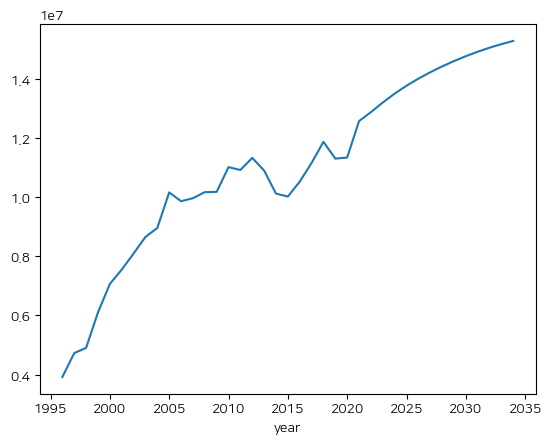

In [46]:
tmp_df["target_civil"].plot()

In [47]:
tmp_weight = df_full.groupby("month")["target_civil"].mean() / df_full.groupby("month")["target_civil"].mean().sum()
print(tmp_weight)

prj_list = []
for i in range(14):
    prj_list.extend([j * tmp_df["target_civil"].iloc[-14:].iloc[i] for j in tmp_weight])
    
df_full["target_civil"].iloc[-14*12:] = prj_list

month
1     0.173742
2     0.144750
3     0.119115
4     0.076037
5     0.047064
6     0.033993
7     0.032381
8     0.030275
9     0.031276
10    0.051903
11    0.099052
12    0.160411
Name: target_civil, dtype: float64


In [48]:
df_full

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price,서울_최고기온,부산_평균습도,korea_pop,gdp
0,1996,Q1,1,6.055190e+05,83809.0,0.87842,12183.433333,0.97,26.94,27.86,2.329032,43.629032,45525.000000,71712.160799
1,1996,Q1,2,5.663230e+05,70427.0,0.88940,12183.433333,0.93,26.94,29.04,3.182759,46.496552,45525.000000,71712.160799
2,1996,Q1,3,4.775140e+05,62652.0,0.88401,12183.433333,0.96,26.94,27.99,9.451613,55.432258,45525.000000,71712.160799
3,1996,Q2,4,3.377940e+05,47050.0,0.87774,12384.133333,0.94,26.94,28.74,15.143333,51.770000,45525.000000,71712.160799
4,1996,Q2,5,1.845220e+05,30709.0,0.85732,12384.133333,0.92,26.94,29.18,24.196774,65.793548,45525.000000,71712.160799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2034,Q3,8,4.627725e+05,NaN,NaN,NaN,NaN,NaN,NaN,30.768387,76.255806,50971.666667,231892.166667
464,2034,Q3,9,4.780701e+05,NaN,NaN,NaN,NaN,NaN,NaN,26.659000,72.548333,50965.750000,231892.166667
465,2034,Q4,10,7.933635e+05,NaN,NaN,NaN,NaN,NaN,NaN,20.743323,62.437742,50959.833333,231892.166667
466,2034,Q4,11,1.514058e+06,NaN,NaN,NaN,NaN,NaN,NaN,12.210000,57.043667,50953.916667,231892.166667


### projection qva (linear inference by gdp)

In [49]:
tmp_df = df_full.groupby("year")[["qva", "gdp"]].sum()
model = lm.LinearRegression()
model.fit(tmp_df.iloc[:-14, [1]], tmp_df.iloc[:-14, 0])
tmp_df.iloc[-14:, 0] = model.predict(tmp_df.iloc[-14:, [1]])

<AxesSubplot: xlabel='year'>

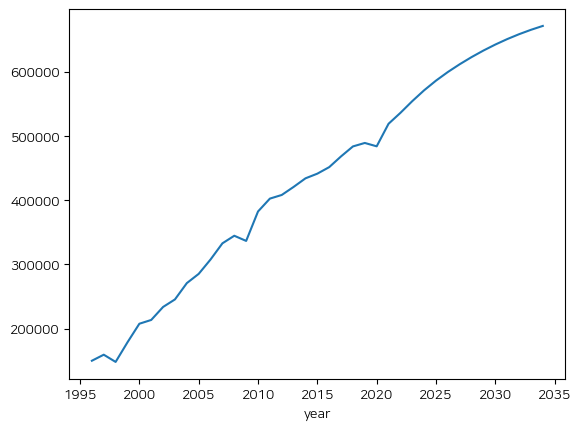

In [50]:
tmp_df["qva"].plot()

In [51]:
tmp_weight = df_full.groupby("quarter")["qva"].mean() / df_full.groupby("quarter")["qva"].mean().sum()
print(tmp_weight)

prj_list = []
for i in range(14):
    prj_list.extend([(j * tmp_df["qva"].iloc[-14:].iloc[i]) for j in tmp_weight])

prj_list_month = []
for i in prj_list:
    prj_list_month.extend([i / 3] * 3)
    
df_full["qva"].iloc[-14*12:] = prj_list_month

quarter
Q1    0.245454
Q2    0.247624
Q3    0.252742
Q4    0.254180
Name: qva, dtype: float64


In [52]:
df_full

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price,서울_최고기온,부산_평균습도,korea_pop,gdp
0,1996,Q1,1,6.055190e+05,83809.0,0.87842,12183.433333,0.97,26.94,27.86,2.329032,43.629032,45525.000000,71712.160799
1,1996,Q1,2,5.663230e+05,70427.0,0.88940,12183.433333,0.93,26.94,29.04,3.182759,46.496552,45525.000000,71712.160799
2,1996,Q1,3,4.775140e+05,62652.0,0.88401,12183.433333,0.96,26.94,27.99,9.451613,55.432258,45525.000000,71712.160799
3,1996,Q2,4,3.377940e+05,47050.0,0.87774,12384.133333,0.94,26.94,28.74,15.143333,51.770000,45525.000000,71712.160799
4,1996,Q2,5,1.845220e+05,30709.0,0.85732,12384.133333,0.92,26.94,29.18,24.196774,65.793548,45525.000000,71712.160799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2034,Q3,8,4.627725e+05,NaN,NaN,56542.251206,NaN,NaN,NaN,30.768387,76.255806,50971.666667,231892.166667
464,2034,Q3,9,4.780701e+05,NaN,NaN,56542.251206,NaN,NaN,NaN,26.659000,72.548333,50965.750000,231892.166667
465,2034,Q4,10,7.933635e+05,NaN,NaN,56863.963656,NaN,NaN,NaN,20.743323,62.437742,50959.833333,231892.166667
466,2034,Q4,11,1.514058e+06,NaN,NaN,56863.963656,NaN,NaN,NaN,12.210000,57.043667,50953.916667,231892.166667


#### set var type

In [53]:
target_vars = ["target_civil", "target_ind"]
target_var = "target_ind"
nontrain_vars = ["year", "weight_civil", "relative_price", "gas_price", "oil_price"]
bin_vars = []
cat_vars = ["quarter", "month"]
num_vars = diff(df_full.columns, nontrain_vars + bin_vars + cat_vars)

# assert len(df_full.columns) == len(nontrain_vars) + len(cat_vars) + len(num_vars)

### Time Feature Engineering

In [54]:
day_secs = 24 * 60 * 60 # 시 분 초
month_secs = (365.2425 / 12) * day_secs
year_secs = (365.2425) * day_secs

In [55]:
timestamp_s = pd.date_range(str(df_full["year"].unique()[0]) + "-01-01", str(df_full["year"].unique()[-1]) + "-12-31", freq="M").map(datetime.datetime.timestamp)

In [56]:
df_full["year_sin"] = np.sin(timestamp_s * (2*np.pi / year_secs))
df_full["year_cos"] = np.cos(timestamp_s * (2*np.pi / year_secs))

In [57]:
df_full["season"] = df_full["month"] % 12 // 3
df_full["year_linear"] = df_full["month"] / 12

cat_vars.append("season")

In [58]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# decompose = seasonal_decompose(df_full[target_vars[1]], period=12, model="additive")
# df_full["decompose_add_trend"] = decompose.trend
# df_full["decompose_add_seasonal"] = decompose.seasonal

# decompose = seasonal_decompose(df_full[target_vars[1]], period=12, model="multiplicative")
# df_full["decompose_mul_trend"] = decompose.trend
# df_full["decompose_mul_seasonal"] = decompose.seasonal

# df_full = df_full.dropna(axis=1)

#### rearrange variables

In [59]:
df_full

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price,서울_최고기온,부산_평균습도,korea_pop,gdp,year_sin,year_cos,season,year_linear
0,1996,Q1,1,6.055190e+05,83809.0,0.87842,12183.433333,0.97,26.94,27.86,2.329032,43.629032,45525.000000,71712.160799,0.488907,0.872336,0,0.083333
1,1996,Q1,2,5.663230e+05,70427.0,0.88940,12183.433333,0.93,26.94,29.04,3.182759,46.496552,45525.000000,71712.160799,0.846681,0.532100,0,0.166667
2,1996,Q1,3,4.775140e+05,62652.0,0.88401,12183.433333,0.96,26.94,27.99,9.451613,55.432258,45525.000000,71712.160799,0.999614,0.027790,1,0.250000
3,1996,Q2,4,3.377940e+05,47050.0,0.87774,12384.133333,0.94,26.94,28.74,15.143333,51.770000,45525.000000,71712.160799,0.883136,-0.469116,1,0.333333
4,1996,Q2,5,1.845220e+05,30709.0,0.85732,12384.133333,0.92,26.94,29.18,24.196774,65.793548,45525.000000,71712.160799,0.522022,-0.852932,1,0.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2034,Q3,8,4.627725e+05,NaN,NaN,56542.251206,NaN,NaN,NaN,30.768387,76.255806,50971.666667,231892.166667,-0.857163,-0.515045,2,0.666667
464,2034,Q3,9,4.780701e+05,NaN,NaN,56542.251206,NaN,NaN,NaN,26.659000,72.548333,50965.750000,231892.166667,-0.999688,-0.024974,3,0.750000
465,2034,Q4,10,7.933635e+05,NaN,NaN,56863.963656,NaN,NaN,NaN,20.743323,62.437742,50959.833333,231892.166667,-0.873568,0.486701,3,0.833333
466,2034,Q4,11,1.514058e+06,NaN,NaN,56863.963656,NaN,NaN,NaN,12.210000,57.043667,50953.916667,231892.166667,-0.519618,0.854399,3,0.916667


In [60]:
num_vars = diff(df_full.columns, [target_var] + nontrain_vars + bin_vars + cat_vars)

In [61]:
num_vars

['target_civil',
 'qva',
 '서울_최고기온',
 '부산_평균습도',
 'korea_pop',
 'gdp',
 'year_sin',
 'year_cos',
 'year_linear']

In [62]:
assert len(df_full.columns) == len([target_var]) + len(nontrain_vars) + len(cat_vars) + len(num_vars)

# Training

## Define Optuna helper function

In [63]:
# optuna function
def optuna_objective_function(trial: Trial, fold, train_x, train_y, train_groups, val_x, val_y, val_groups, categoIdx,
                              model_name, output_container, ntrees=1000, eta=1e-2, direction="minimize", TF=True, target_scaler=None):
    best_ntrees = None

    if model_name == "LGB_RF":
        # objective
        # regession : "mae", "mse"
        # classification - binary : "binary"
        # classification - binary : "multiclass" (num_class=n)
        # ranking : "xe_ndcg_mart"

        # metric
        # regession : "mae", "mse", "rmse"
        # classification - binary : "binary_logloss", "binary_error", "auc"
        # classification - muticlass : "multi_logloss", "multi_error"
        # ranking : "ndcg", "map"

        tuning_params = {
#             "n_estimators": trial.suggest_int("n_estimators", 50, 100, step=10),
            # "learning_rate": trial.suggest_categorical("learning_rate", [1e-2, 5e-3, 1e-3]),
            "num_leaves": trial.suggest_categorical("num_leaves", [pow(2, i) - 1 for i in [4, 5, 6, 7, 8]]),
            # goss sampling hyper-parameter replacing the "sumample"
            "subsample": trial.suggest_float("subsample", 0.5, 0.8, step=0.1),
            "subsample_freq": trial.suggest_int("subsample_freq", 1, 10, step=1),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8, step=0.1),
            "reg_alpha": trial.suggest_categorical("reg_alpha", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            "reg_lambda": trial.suggest_categorical("reg_lambda", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            "min_child_weight": trial.suggest_categorical("min_child_weight", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            "min_child_samples": trial.suggest_int("min_child_samples", 1, 51, step=2),
            "min_gain_to_split": trial.suggest_categorical("min_gain_to_split", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            # # for binary
            # "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
        }
        model = lgb.LGBMRegressor(boosting_type="rf", objective="mse",
                                   n_estimators=100, device_type="cpu",
                                   random_state=fold, verbose=-1, **tuning_params)
        cb_list = [
            lgb.early_stopping(stopping_rounds=20, first_metric_only=True, verbose=False),
        ]

        model.fit(train_x, train_y, categorical_feature=categoIdx,
            eval_set=(val_x,val_y), eval_metric="rmse", callbacks=cb_list)
        best_ntrees = model.best_iteration_

#         model = lgb.LGBMRegressor(boosting_type="rf", objective="mae",
#                                    n_estimators=int(ntrees / 10), device_type="cpu",
#                                    random_state=fold, verbose=-1, **tuning_params)
#         model = RegressorChain(model, cv=None, random_state=fold)
#         model.fit(train_x, train_y)
    elif model_name == "LGB_GOSS":
        # objective
        # regession : "mae", "mse"
        # classification - binary : "binary"
        # classification - binary : "multiclass" (num_class=n)
        # ranking : "xe_ndcg_mart"

        # metric
        # regession : "mae", "mse", "rmse"
        # classification - binary : "binary_logloss", "binary_error", "auc"
        # classification - muticlass : "multi_logloss", "multi_error"
        # ranking : "ndcg", "map"

        tuning_params = {
#             "learning_rate": trial.suggest_categorical("learning_rate", [1e-2, 5e-3, 1e-3]),
            "num_leaves": trial.suggest_categorical("num_leaves", [pow(2, i) - 1 for i in [4, 5, 6, 7, 8]]),
            # goss sampling hyper-parameter replacing the "sumample"
            "top_rate": trial.suggest_float("top_rate", 0.2, 0.5, step=0.1),
            "other_rate": trial.suggest_float("other_rate", 0.2, 0.5, step=0.1),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8, step=0.1),
            "reg_alpha": trial.suggest_categorical("reg_alpha", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            "reg_lambda": trial.suggest_categorical("reg_lambda", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            "min_child_weight": trial.suggest_categorical("min_child_weight", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            "min_child_samples": trial.suggest_int("min_child_samples", 1, 51, step=2),
            "min_gain_to_split": trial.suggest_categorical("min_gain_to_split", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            # # for binary
            # "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
        }
        model = lgb.LGBMRegressor(boosting_type="goss", objective="mse",
                                   n_estimators=ntrees, device_type="cpu",
                                   random_state=42, verbose=-1, **tuning_params)
        cb_list = [
            lgb.early_stopping(stopping_rounds=int(ntrees * 0.2), first_metric_only=True, verbose=False),
        ]
        model.fit(train_x, train_y, categorical_feature=categoIdx,
                  eval_set=(val_x,val_y), eval_metric="rmse", callbacks=cb_list)
        
#         model = lgb.LGBMRegressor(boosting_type="goss", objective="mae",
#                            n_estimators=ntrees, learning_rate=eta, device_type="cpu",
#                            random_state=fold, verbose=-1, **tuning_params)
#         model = RegressorChain(model, cv=None, random_state=fold)
#         model.fit(train_x, train_y)
#         best_ntrees = model.best_iteration_
    elif model_name == "LGB_GBM":
        # objective
        # regession : "mae", "mse"
        # classification - binary : "binary"
        # classification - binary : "multiclass" (num_class=n)
        # ranking : "xe_ndcg_mart"

        # metric
        # regession : "mae", "mse", "rmse"
        # classification - binary : "binary_logloss", "binary_error", "auc"
        # classification - muticlass : "multi_logloss", "multi_error"
        # ranking : "ndcg", "map"

        tuning_params = {
#             "learning_rate": trial.suggest_categorical("learning_rate", [1e-2, 5e-3, 1e-3]),
#             "learning_rate": trial.suggest_categorical("learning_rate", [1e-2]),
            "num_leaves": trial.suggest_categorical("num_leaves", [pow(2, i) - 1 for i in [4, 5, 6, 7, 8]]),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8, step=0.1),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8, step=0.1),
            "reg_lambda": trial.suggest_categorical("reg_lambda", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            "min_child_weight": trial.suggest_categorical("min_child_weight", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            "min_child_samples": trial.suggest_int("min_child_samples", 1, 51, step=2),
            "min_gain_to_split": trial.suggest_categorical("min_gain_to_split", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            # # for binary
            # "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
        }

#         model = lgb.LGBMRegressor(boosting_type="gbdt", objective="mae",
#                                    n_estimators=ntrees, device_type="cpu",
#                                    random_state=fold, verbose=-1, **tuning_params)
#         cb_list = [
#             lgb.early_stopping(stopping_rounds=int(ntrees * 0.2), first_metric_only=True, verbose=False, min_delta=0.001),
#         ]
#         model.fit(train_x, train_y, categorical_feature=categoIdx,
#                   eval_set=(val_x,val_y), eval_metric="mae", callbacks=cb_list)
#         best_ntrees = model.best_iteration_
        
        model = lgb.LGBMRegressor(boosting_type="gbdt", objective="mae",
                   n_estimators=ntrees, learning_rate=eta, device_type="cpu",
                   random_state=42, verbose=-1, **tuning_params)
#         model = RegressorChain(model, cv=None, random_state=fold)
        model.fit(train_x, train_y)
    elif model_name == "XGB_GBT":
        # objective
        # regession : "reg:absoluteerror", "reg:squarederror"
        # classification - binary : "binary:logistic"
        # classification - multicalss :"multi:softmax" (num_class=n)
        # ranking : "rank:ndcg"

        # metric
        # regession : "mae", "rmse"
        # classification - binary : "logloss", "error@t" (t=threshold), "auc"
        # classification - multicalss : "mlogloss", "merror"
        # ranking : "ndcg", "map"

        tuning_params = {
#             "learning_rate": trial.suggest_categorical("learning_rate", [1e-2, 5e-3, 1e-3]),
            "max_depth": trial.suggest_categorical("max_depth", [4, 5, 6, 7, 8]),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8, step=0.1),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8, step=0.1),
            "reg_lambda": trial.suggest_categorical("reg_lambda", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            "min_child_weight": trial.suggest_categorical("min_child_weight", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            "gamma": trial.suggest_categorical("gamma", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
#             # for binary
#             "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
        }
        model = xgb.XGBRegressor(booster="gbtree", objective="reg:squarederror",
                            n_estimators=ntrees, learning_rate=eta,
                            random_state=fold, verbosity=0, **tuning_params)
        model.fit(train_x, train_y,
                  eval_set=[(val_x, val_y)], eval_metric="rmse",
                  early_stopping_rounds=int(ntrees * 0.2), verbose=False)
        best_ntrees = model.best_iteration
        
#         model = xgb.XGBRegressor(booster="gbtree", objective="reg:squarederror",
#                     n_estimators=ntrees, learning_rate=eta,
#                     random_state=fold, verbosity=0, **tuning_params)
#         model = RegressorChain(model, cv=None, random_state=fold)
#         model.fit(train_x, train_y)
    elif model_name == "CAT_GBM":
        # objective
        # regession : "MAE", "RMSE", "MAPE"
        # classification - binary : "Logloss"
        # classification - multicalss :"MultiClass"
        # ranking : "PairLogit", "YetiRank"

        # metric
        # regession : "MAE", "RMSE", "R2"
        # classification - binary : "Logloss", "Accuracy", "AUC", "F1"
        # classification - multicalss : "MultiClass", "Accuracy", "TotalF1" (average=Weighted,Macro,Micro)
        # ranking : "PairLogit", "YetiRank", "NDCG", "MAP"

        tuning_params = {
#             "learning_rate": trial.suggest_categorical("learning_rate", [5e-3]),
            "max_depth": trial.suggest_categorical("max_depth", [4, 6, 8]),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.1, 1.0, step=0.1),
#             rsm = colsample_bylevel (not supported for GPU)
            "rsm": trial.suggest_float("rsm", 0.5, 0.8, step=0.1),
            "random_strength": trial.suggest_categorical("random_strength", [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]),
            "reg_lambda": trial.suggest_categorical("reg_lambda", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            "min_child_samples": trial.suggest_int("min_child_samples", 1, 10 if CFG.debug else 51, step=2),
            # # for binary
            # "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
        }

        model = cat.CatBoostRegressor(boosting_type="Plain", loss_function="RMSE", eval_metric="RMSE",
                            n_estimators=ntrees, learning_rate=eta, bootstrap_type="Bayesian",
                            verbose=False, random_state=fold, **tuning_params)
        # model = cat.CatBoostClassifier(boosting_type="Plain", loss_function="Logloss", eval_metric="Logloss",
        #                             n_estimators=ntrees, task_type="GPU", bootstrap_type="Bayesian",
        #                             verbose=False, random_state=fold, **tuning_params)
        
        global x1, x2, y1, y2, model_cat, tun
        tun = copy.deepcopy(tuning_params)
        
        x1 = train_x.copy()
        y1 = train_y.copy()
        
        x2 = val_x.copy()
        y2 = val_y.copy()
        
#         model_cat = copy.deepcopy(model)
        
        model.fit(train_x, train_y, cat_features=categoIdx,
                eval_set=[(val_x, val_y)], early_stopping_rounds=int(ntrees * 0.2), use_best_model=True,
                verbose=False)
        best_ntrees = model.best_iteration_
#         model = RegressorChain(model, cv=None, random_state=fold)
#         model.fit(train_x, train_y)
        
    elif model_name == "CAT_ORD":
        # objective
        # regession : "MAE", "RMSE"
        # classification - binary : "Logloss"
        # classification - multicalss :"MultiClass"
        # ranking : "PairLogit", "YetiRank"

        # metric
        # regession : "MAE", "RMSE", "R2"
        # classification - binary : "Logloss", "Accuracy", "AUC", "F1"
        # classification - multicalss : "MultiClass", "Accuracy", "TotalF1" (average=Weighted,Macro,Micro)
        # ranking : "PairLogit", "YetiRank", "NDCG", "MAP"

        tuning_params = {
            "learning_rate": trial.suggest_categorical("learning_rate", [5e-3]),
            "max_depth": trial.suggest_categorical("max_depth", [4, 6, 8]),
            # "bagging_temperature": trial.suggest_categorical("bagging_temperature", list(np.linspace(1e-3, 1.0, num=75, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=25, endpoint=True))),
            # rsm = colsample_bylevel (not supported for GPU)
            # "rsm": trial.suggest_float("rsm", 0.5, 0.8, step=0.1),
            "random_strength": trial.suggest_categorical("random_strength", [0.01, 0.1, 1.0, 2.0, 3.0]),
            "reg_lambda": trial.suggest_categorical("reg_lambda", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            # "min_child_samples": trial.suggest_float("min_child_samples", 1, 51, step=2),
            # for binary
            "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
        }

        model = cat.CatBoostClassifier(boosting_type="Ordered", loss_function="Logloss", eval_metric="Logloss",
                                    n_estimators=ntrees, task_type="CPU", bootstrap_type="Bayesian",
                                    verbose=False, random_state=fold, **tuning_params)
        model.fit(train_x, train_y, cat_features=categoIdx,
                eval_set=[(val_x, val_y)], early_stopping_rounds=int(ntrees * 0.2), use_best_model=True,
                verbose=False)
        best_ntrees = model.best_iteration_
    elif model_name == "ElasticNet":
        # # for classification
        # tuner_params = {
        #     "C": trial.suggest_categorical("C", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
        #     "l1_ratio": trial.suggest_float("l1_ratio", 0.0, 1.0, step=0.05)
        # }

        # model = lm.LogisticRegression(penalty="elasticnet", solver="saga", multi_class="ovr", random_state=fold, n_jobs=-1, **tuner_params)

        # for regression
        tuner_params = {
            "alpha": trial.suggest_categorical("C", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            "l1_ratio": trial.suggest_float("l1_ratio", 0.0, 1.0, step=0.05)
        }

        model = lm.ElasticNet(**tuner_params, random_state=fold)
#         model = RegressorChain(model, cv=None, random_state=42)
#         model = RegressorChain(model)
        model.fit(train_x, train_y)

#         # for RAPIDS module
#         model = cuml.ElasticNet(**tuner_params, output_type="numpy")
#         model.fit(cupy.asarray(train_x), cupy.asarray(train_y))
    elif model_name == "CalibratedClassifier_SVM":
        tuner_params = {
            "C": trial.suggest_categorical("C", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf"]),
        }
        model_base = svm.SVC(max_iter=100, random_state=fold, **tuner_params)
        model_base.fit(train_x, train_y)

        model = CalibratedClassifierCV(base_estimator=model_base, method='sigmoid', cv="prefit", n_jobs=-1)
        model.fit(val_x, val_y)
    elif model_name == "KNN":
        tuner_params = {
            "n_neighbors": trial.suggest_int("n_neighbors", 1, 12, step=1),
            "weights": trial.suggest_categorical("kernel", ["uniform", "distance"]),
        }

#         model = KNeighborsClassifier(n_jobs=-1, **tuner_params)
#         model.fit(train_x, train_y)
        
        model = KNeighborsRegressor(n_jobs=None, **tuner_params)
#         model = RegressorChain(model, cv=None, random_state=fold)
        model.fit(train_x, train_y)
    elif model_name == "MLP":
        hidden_layer_units = trial.suggest_categorical("hidden_layer_units", [8, 16, 32, 64])
        hidden_layer_depth = trial.suggest_categorical("hidden_layer_depth", [1, 2, 3, 4])
        tuner_params = {
            "activation": "relu",
            "solver": "adam",
            "learning_rate": "constant",
            "learning_rate_init": 5e-4,
            "hidden_layer_sizes": tuple([hidden_layer_units] * hidden_layer_depth),
            "max_iter": trial.suggest_int("max_iter", 5, 100, 5),
            "batch_size": trial.suggest_categorical("batch_size", [1, 4, 8]),
            "early_stopping": False,
            "shuffle": True,
            "random_state": 42,
        }
        
        model = MLPRegressor(**tuner_params)
#         model = RegressorChain(model, cv=None, random_state=fold)
        model.fit(train_x, train_y)
    elif model_name == "ExtraTree":
        tuning_params = {
            "max_depth": trial.suggest_categorical("max_depth", [4, 5, 6, 7, 8, 9, 19]),
            "max_features": trial.suggest_float("max_features", 0.5, 0.8, step=0.1),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 51, step=2),
        }
        
        model = ExtraTreeRegressor(splitter="best", random_state=42, **tuning_params)
        model = RegressorChain(model, cv=None, random_state=fold)
        model.fit(train_x, train_y)
    else:
        print("unknown")
        return -1
    
    # # predict
    pred = model.predict(val_x)
    pred = np.expm1(pred) if TF else pred
    optuna_score = skl_merics.mean_absolute_percentage_error(df_full_y[valid_idx], pred, multioutput="uniform_average")

    if direction == "minimize":
        if optuna_score < output_container["score"]:
            if best_ntrees is not None:
                print("best_ntrees :", best_ntrees)
            output_container["model"] = model
            output_container["pred"] = pred
            output_container["score"] = optuna_score
            output_container["best_ntrees"] = best_ntrees
    else:
        if optuna_score > output_container["score"]:
            if best_ntrees is not None:
                print("best_ntrees :", best_ntrees)
            output_container["model"] = model
            output_container["pred"] = pred
            output_container["score"] = optuna_score
            output_container["best_ntrees"] = best_ntrees
    return optuna_score


import operator
class Optuna_EarlyStoppingCallback(object):
    """Early stopping callback for Optuna."""

    def __init__(self, early_stopping_rounds: int, direction: str = "minimize") -> None:
        self.early_stopping_rounds = early_stopping_rounds

        self._iter = 0

        if direction == "minimize":
            self._operator = operator.lt
            self._score = np.inf
        elif direction == "maximize":
            self._operator = operator.gt
            self._score = -np.inf
        else:
            ValueError(f"invalid direction: {direction}")

    def __call__(self, study: optuna.Study, trial: optuna.Trial) -> None:
        """Do early stopping."""
        if self._operator(study.best_value, self._score):
            self._iter = 0
            self._score = study.best_value
        else:
            self._iter += 1

        if self._iter >= self.early_stopping_rounds:
            study.stop()

In [64]:
model_name_list = ["ElasticNet", "LGB_RF", "LGB_GOSS", "XGB_GBT", "CAT_GBM", "KNN", "MLP"]

feature_version = 3

TF = False
tuning = True
correct_overshoot = False

architecture_name = "fv" + str(feature_version) + "_projection_noTF_vanillaTimeFE_5folds_" + "after2000_allModels_minmax" + "_try1"
architecture_root_path = folder_path + "architectures\\" + architecture_name + "\\"
if not os.path.exists(architecture_root_path):
    os.makedirs(architecture_root_path)
shutil.copy(folder_path + "YJ_modeling_projection.ipynb", architecture_root_path + "YJ_modeling_projection.ipynb")
createFolder(architecture_root_path + "model\\")
createFolder(architecture_root_path + "scaler\\")

feature_type_dic = {
    "target_vars": target_vars,
    "target_var": target_var,
    "nontrain_vars": nontrain_vars,
    "bin_vars": bin_vars,
    "cat_vars": cat_vars,
    "num_vars": num_vars,
}

try:
    pickleIO(CFG,  architecture_root_path + "CFG.pkl", "w")
    pickleIO(model_name_list,  architecture_root_path + "model_name_list.pkl", "w")
    pickleIO(df_full.iloc[:-14*12].reset_index(drop=True), architecture_root_path + "df_full.pkl", "w")
    pickleIO(df_full.iloc[-14*12:].reset_index(drop=True).drop(target_var, axis=1), architecture_root_path + "df_test.pkl", "w")
    pickleIO(feature_type_dic, architecture_root_path + "feature_type_dic.pkl", "w")
except:
    print("already saved")

In [66]:
df_full = pickleIO(None, architecture_root_path + "df_full.pkl", "r")

df_full = df_full[df_full["year"] >= 2000].reset_index(drop=True)

df_full = df_full.sample(frac=1, random_state=42).reset_index(drop=True)
df_full_x = df_full.drop(target_var, axis=1)
df_full_y = df_full[target_var]
del df_full

In [67]:
df_full_x = df_full_x.drop(nontrain_vars, axis=1)

In [68]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(df_full_x[cat_vars])

cat_oh_vars = []
for idx, value in enumerate(cat_vars):
    cat_oh_vars += [value + "_" + str(j) for j in ohe.categories_[idx]]

df_full_x = pd.concat([df_full_x.drop(cat_vars, axis=1), pd.DataFrame(ohe.transform(df_full_x[cat_vars]), columns=cat_oh_vars)], axis=1)
pickleIO(ohe, architecture_root_path + "cat_ohe.pkl", "w")

0

In [69]:
df_full_x

,target_civil,qva,서울_최고기온,부산_평균습도,korea_pop,gdp,year_sin,year_cos,year_linear,quarter_Q1,...,month_7,month_8,month_9,month_10,month_11,month_12,season_0,season_1,season_2,season_3
0,1914895.0,34127.900000,-0.519355,47.425806,50200.000000,147206.744781,-0.007354,0.999973,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,1294043.0,39392.733333,13.596774,62.870968,51417.750000,176096.228044,0.999437,0.033550,0.250000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,312720.0,29492.600000,26.876667,71.910000,48962.250000,128788.872781,-0.999805,-0.019728,0.750000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,237249.0,12790.800000,19.416129,63.770968,45525.000000,71712.160799,-0.871762,0.489929,0.833333,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,373618.0,36644.066667,29.463333,80.270000,50881.000000,161131.493848,0.043574,-0.999050,0.500000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,335737.0,33569.366667,26.573333,65.506667,49841.250000,143753.033597,-0.999480,-0.032239,0.750000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
296,1246694.0,18084.700000,3.438710,44.525806,47370.000000,92070.730007,-0.013074,0.999915,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
297,853352.0,22820.566667,13.413333,56.396667,48067.083333,107622.109772,-0.515570,0.856848,0.916667,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
298,397534.0,40783.000000,32.132258,77.706452,51492.083333,176096.228044,-0.474492,-0.880260,0.583333,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [70]:
df_full_y

0      953413.0
1      647226.0
2      417851.0
3       61954.0
4      514007.0
         ...   
295    520233.0
296    325748.0
297    333831.0
298    589012.0
299    248155.0
Name: target_ind, Length: 300, dtype: float64

## Training

**learning parameter setting**

In [71]:
def do_fold_training(fold, train_idx, valid_idx, TF=True, apply_pca=False, tuning=False):

    train_x = df_full_x.iloc[train_idx].reset_index(drop=True)

    scaler = MinMaxScaler()

    if apply_pca:
        pca = PCA(16)
        train_x = df_full_x.iloc[train_idx].reset_index(drop=True)
        pca.fit(scaler.fit_transform(train_x[num_vars]))
        n_comp = np.where(pca.explained_variance_ratio_.cumsum() > CFG.pca_threshold)[0][0] + 1

        train_x = pd.concat([
            train_x.drop(num_vars, axis=1).reset_index(drop=True),
            pd.DataFrame(pca.transform(scaler.transform(train_x[num_vars]))[:, :n_comp]).reset_index(drop=True)
        ], axis=1)
    else:
        train_x[num_vars] = scaler.fit_transform(train_x[num_vars]) if scaler is not None else train_x
    train_y = df_full_y.iloc[train_idx].reset_index(drop=True)
    train_y = np.log1p(train_y) if TF else train_y

    valid_x = df_full_x.iloc[valid_idx].reset_index(drop=True)
    if apply_pca:
        valid_x = pd.concat([
            valid_x.drop(num_vars, axis=1).reset_index(drop=True),
            pd.DataFrame(pca.transform(scaler.transform(valid_x[num_vars]))[:, :n_comp]).reset_index(drop=True)
        ], axis=1)
    else:
        valid_x[num_vars] = scaler.transform(valid_x[num_vars]) if scaler is not None else valid_x
    valid_y = df_full_y.iloc[valid_idx].reset_index(drop=True)
    valid_y = np.log1p(valid_y) if TF else valid_y

    if model_name not in ["Linear", "BayesianRidge"]:
        output_container = {"model": None, "pred": None, "score": np.inf, "best_ntrees": None}
        optuna_direction = 'minimize'
        optuna_trials = 3 if CFG.debug else 300
        optuna_timout = max(60, int(3 * 3600 / CFG.n_folds / (len(model_name_list))))
        optuna_earlyStopping = Optuna_EarlyStoppingCallback(max(1, int(optuna_trials * 0.2)), direction=optuna_direction)
        optuna_study = create_study(direction=optuna_direction, sampler=TPESampler())
        optuna_study.optimize(
            lambda trial: optuna_objective_function(
                trial, fold,
                train_x=train_x.to_numpy(),
                train_y=train_y.to_numpy(),
                train_groups=None,
                val_x=valid_x.to_numpy(),
                val_y=valid_y.to_numpy(),
                val_groups=None,
                categoIdx=None, model_name=model_name, output_container=output_container,
                ntrees=ntrees, eta=eta, direction=optuna_direction, TF=TF
            ),
            n_jobs=1, n_trials=optuna_trials, timeout=optuna_timout,
            callbacks=[optuna_earlyStopping],
        )

        model = output_container["model"]
    elif model_name == "BayesianRidge":
        model = lm.BayesianRidge()
        model.fit(train_x, train_y)
    else:
        model = lm.LinearRegression()
        model.fit(train_x, train_y)

    tmp_pred = model.predict(valid_x)
    tmp_pred = np.expm1(tmp_pred) if TF else tmp_pred
    valid_pred[valid_idx, 0] = tmp_pred

    metric_list["MAE"].append(skl_merics.mean_absolute_error(df_full_y.iloc[valid_idx].values, tmp_pred))
    metric_list["MAPE"].append(skl_merics.mean_absolute_percentage_error(df_full_y.iloc[valid_idx].values, tmp_pred, multioutput="uniform_average"))

    pickleIO(model, architecture_root_path + "model\\" + model_name + "_fold" + str(fold) + ".pkl", "w")
    pickleIO(scaler, architecture_root_path + "scaler\\" + model_name + "_fold" + str(fold) + ".pkl", "w")

In [72]:
ntrees = 100 if CFG.debug else 1000
eta = 1e-2

model_output_dic = dict.fromkeys(model_name_list)

for model_name in model_name_list:
    seed_everything()
    
    metric_list = {
        "MAE": [],
        "MAPE": []
    }

    kfolds_spliter = StratifiedKFold(CFG.n_folds, shuffle=True, random_state=42)
    startVec = skl.preprocessing.KBinsDiscretizer(CFG.n_folds, encode="ordinal").fit_transform(df_full_y.to_frame()).flatten().astype("int32")
    valid_pred = np.zeros(shape=(len(df_full_x), 1))
    
    for fold, (train_idx, valid_idx) in enumerate(kfolds_spliter.split(df_full_x, startVec)):
        train_idx = train_idx[:100] if CFG.debug else train_idx
        valid_idx = valid_idx[:100] if CFG.debug else valid_idx

        do_fold_training(fold, train_idx, valid_idx, TF=TF, apply_pca=False, tuning=tuning)
        gc.collect()
    
    model_output_dic[model_name] = {
        "valid_pred": valid_pred,
        "metric_list": metric_list,
    }

## Summarize score

In [73]:
mae_list = []
mape_list = []

for k in model_output_dic.keys():
    mae_list.append(np.nanmean(model_output_dic[k]["metric_list"]["MAE"]))
    mape_list.append(np.nanmean(model_output_dic[k]["metric_list"]["MAPE"]))
    
score_table = pd.DataFrame({"MAE": mae_list, "MAPE": mape_list}, index=model_name_list)
score_table.loc["average"] = score_table.iloc[:len(model_name_list)].mean(axis=0)
score_table.loc["std"] = score_table.iloc[:len(model_name_list)].std(axis=0)
display(score_table)
score_table.to_csv(architecture_root_path + "target_ind_score_table.csv", index=False)

,MAE,MAPE
Linear,44027.221229,0.154091
average,44027.221229,0.154091
std,NaN,NaN


## Get score weight & ensemble prediction

In [74]:
ensemble_weight = (1 / score_table["MAPE"].iloc[:len(model_name_list)]) / np.sum(1 / score_table["MAPE"].iloc[:len(model_name_list)])
pickleIO(ensemble_weight, architecture_root_path + "ensemble_weight.pkl", "w")
display(ensemble_weight)

ensemble_valid_pred = np.stack([model_output_dic[i]["valid_pred"] * ensemble_weight.loc[i] for i in model_output_dic.keys()]).sum(axis=0)
# last_ensemble_test_pred = ensemble_test_pred[-1]

ensemble_valid_pred = ensemble_valid_pred.flatten()

Linear    1.0
Name: MAPE, dtype: float64

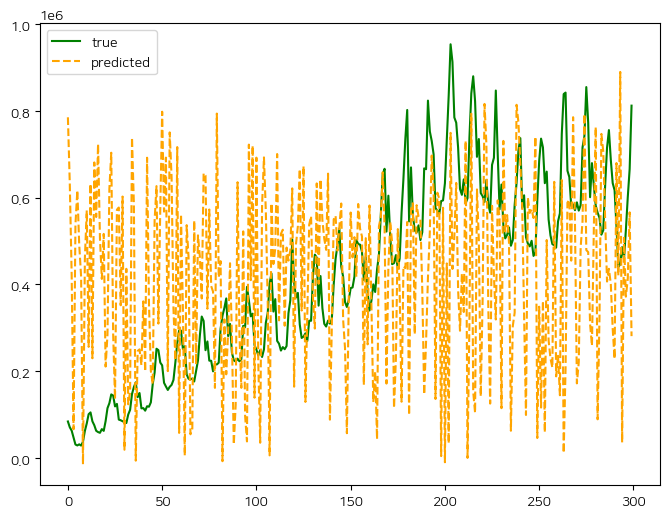

In [75]:
df_full = pickleIO(None, architecture_root_path + "df_full.pkl", "r")
plt.figure(figsize=(8, 6))
plt.plot(df_full[target_var], color="green", label="true")
plt.plot(ensemble_valid_pred, color="orange", linestyle="--", label="predicted")
plt.legend()
plt.show()

In [76]:
if correct_overshoot:
    # correct overshoting
    threshold_pct_change = 0.2

    tmp = pd.Series(ensemble_valid_pred)
    for idx, value in enumerate(tmp.pct_change().abs() > threshold_pct_change):
        if value:
            max_pct_change = (tmp.iloc[idx] / np.abs(tmp.iloc[idx])) * (threshold_pct_change) 
            tmp.iloc[idx] = tmp.iloc[idx-1] * (1+max_pct_change)
    ensemble_valid_pred = tmp

In [77]:
ensemble_valid_pred[:5]

array([785072.41592693, 632085.34433383, 421059.61367947,  65959.79693229,
       538119.05586505])

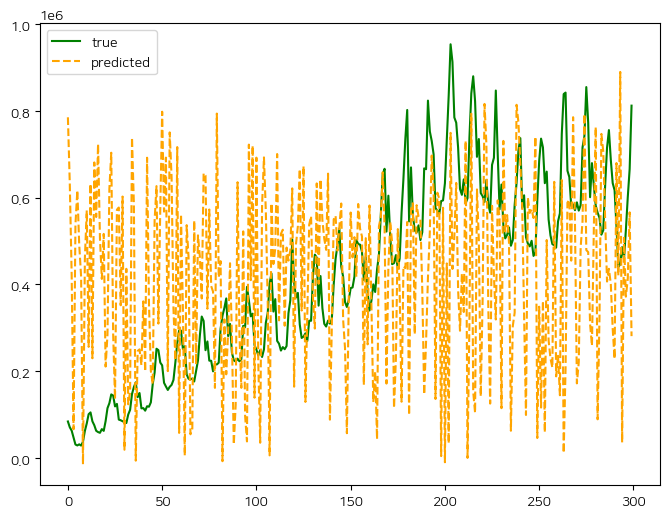

In [78]:
plt.figure(figsize=(8, 6))
plt.plot(df_full[target_var], color="green", label="true")
plt.plot(ensemble_valid_pred, color="orange", linestyle="--", label="predicted")
plt.legend()
plt.show()